##### Imports:
Import packages and load modells

In [1]:
from collections import Counter

import numpy as np
import spacy
from matplotlib import pyplot as plt
import re

from enum import Enum

nlp = spacy.load('de_core_news_md')


##### Preprocessing and structure:

In [2]:
class Party(Enum):
    AFD = 0
    CDU = 1
    FDP = 2
    GRUENE = 3
    LINKE = 4
    SPD = 5


In [9]:
def all_statistics(party: Party):
    with open('resources/' + party.name + '.txt', encoding='utf-8', errors='ignore') as txt:
        file = " ".join(l.rstrip() for l in txt)
    text = nlp(file)
    words = [token.lemma_ for token in text
             if not (token.is_stop
                     or token.is_punct
                     or token.is_space
                     or token.like_num
                     or token.like_url
                     or token.like_email
                     or token.is_currency
                     or token.text.upper() == party.name
                     or token.pos_ == 'VBZ'  # Verb, 3rd person singular present
                     or token.pos_ == 'ADP'  # adposition
                     or token.pos_ == 'PRON'  # pronoun
                     or token.pos_ == 'AUX'  # auxiliary
                     or token.text == '>'
                     or (party == Party.FDP and (token.text == 'Freie' or token.text == 'Demokraten'))
                     or not re.match('[\x00-\x7F]+', token.text))]  # remove non ascii
    word_freq = Counter(words)
    most_freq_nouns = word_freq.most_common(50)
    return text, words, word_freq, most_freq_nouns

Gather statistics for all parties

In [10]:
# statistics_tuple = (text, words, word_freq, most_freq_nouns)
statistics = {}

for party in Party:
    statistics[party] = all_statistics(party)

print('Loading statistics is finished!')


Loading statistics is finished!


##### Plotting:

In [35]:
def plottingPng(most_freq_words, name, show_plot=True, save_plot=False):
    ranked_frequencies = []
    x_axis = []
    y_axis = []

    for i, word in zip(range(len(most_freq_words)), most_freq_words):
        ranked_frequencies.insert(i, word)


    i = 0
    for (x, y) in ranked_frequencies:
        x_axis.insert(i, x)
        y_axis.insert(i, y)
        i += 1

    y = np.arange(50)
    plt.rcParams['figure.autolayout'] = True
    fig, ax = plt.subplots()
    ax.bar(y, y_axis, .5, color='blue')
    ax.set_xticks(y, labels=x_axis, rotation=45, ha='right')

    ax.tick_params(labelcolor='white')

    fig.set_figwidth(fig.get_figwidth() * 2)
    plt.title(name, color='white')

    if save_plot:
        plt.savefig('graphs/graph_' + name + '.svg', format='svg')
    if show_plot:
        plt.show()

Plot the most frequent words for all parties

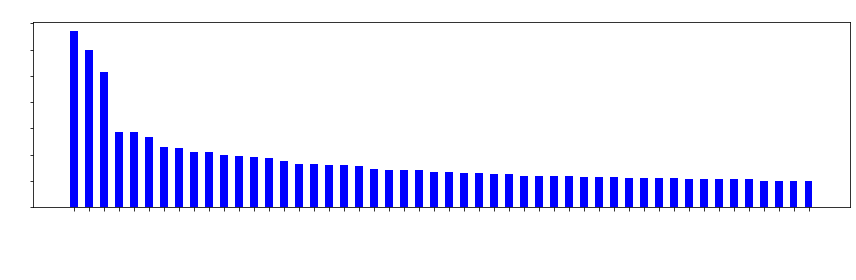

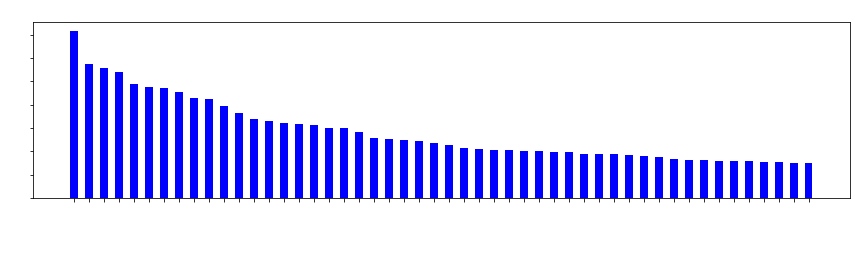

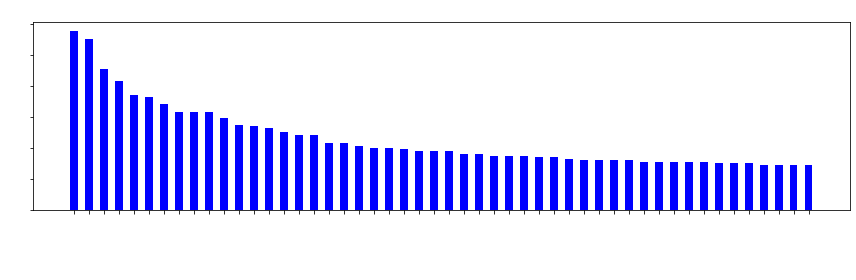

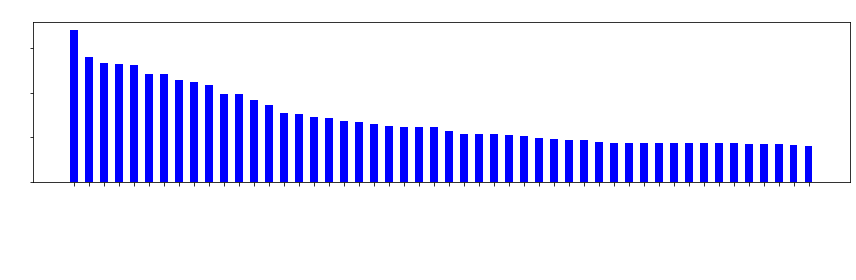

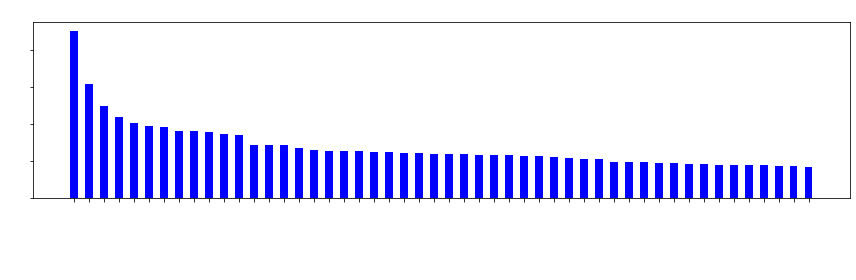

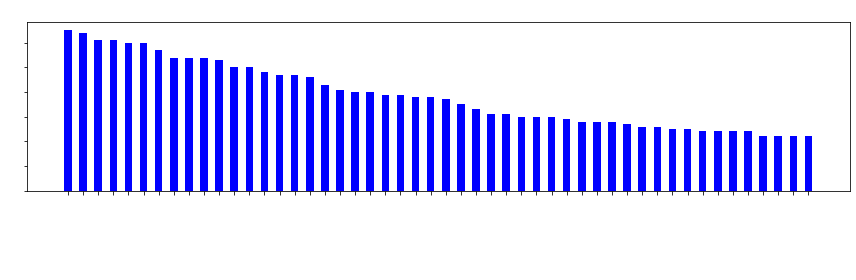

In [36]:
for party in Party:
    plottingPng(statistics[party][3], party.name)
